<a href="https://colab.research.google.com/github/crd3cc04/Unit-2-Project-Build-/blob/master/Cortesha_RosaRobinson_Unit_2_Build_Pima_Indian_Diabetes_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading Data

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install catboost
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
from google.colab import files
uploaded = files.upload()

Saving pima-indians-diabetes-database.zip to pima-indians-diabetes-database (2).zip


In [0]:
!pwd

/content


In [0]:
! unzip pima-indians-diabetes-database.zip
! ls

Archive:  pima-indians-diabetes-database.zip
replace diabetes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
 catboost_info	'pima-indians-diabetes-database (1).zip'   sample_data
 cb_model.json	'pima-indians-diabetes-database (2).zip'
 diabetes.csv	 pima-indians-diabetes-database.zip


In [0]:
import numpy as np
import pandas as pd
# Pima Indian dataset......
df = pd.read_csv('diabetes.csv')
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [0]:
df= df.drop(columns='DiabetesPedigreeFunction')

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
print(train.shape, test.shape)

(614, 8) (154, 8)


# Finding the Baseline

In [0]:
train['Outcome'].value_counts(normalize=True)

0    0.661238
1    0.338762
Name: Outcome, dtype: float64

# Spliting my Dataset into Train, Validation, and Test

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Splitting the train, valdiation, and test data....
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Outcome'], random_state=42)
train.shape, val.shape, test.shape

((491, 8), (123, 8), (154, 8))

# Fitting my Train Dataset

In [0]:
# Arrange data into X features matrix and y target vector 
target = 'Outcome'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

print(X_train.shape, X_val.shape, X_test.shape)

(491, 7) (123, 7) (154, 7)


### Logistic Regression

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=1)
)

lr.fit(X_train, y_train)
score = lr.score(X_val, y_val)
print('Logistic Regression, Validation Accuracy', score) # Scored a 78%, which is pretty good with this model 

Logistic Regression, Validation Accuracy 0.7804878048780488


### Catboost Classifier

In [0]:
from catboost import CatBoostClassifier # On the validation data.......
model = CatBoostClassifier(random_seed= 50)
# Fit model
model.fit(X_train, y_train)
# Get predicted classes
preds_class = model.predict(X_val)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_val)
# Get predicted RawFormulaVal
preds_raw = model.predict(X_val, prediction_type='RawFormulaVal')

In [0]:
# Fit model on the test data.......
model.fit(X_train, y_train)
# Get predicted classes
preds_class1 = model.predict(X_test)
# Get predicted probabilities for each class
preds_proba1 = model.predict_proba(X_test)
# Get predicted RawFormulaVal
preds_raw1 = model.predict(X_test, prediction_type='RawFormulaVal')

### ROC AUC Score

In [0]:
from sklearn.metrics import roc_auc_score
# preds_class = model.predict(X_val)# Probability for last class
print('Validation ROC AUC:', roc_auc_score(y_val, preds_class))
print('Test ROC AUC:', roc_auc_score(y_test, preds_class1))

Validation ROC AUC: 0.699294532627866
Test ROC AUC: 0.6671985815602837


##### Looking at these show that there was somthing in the features that didn't really contribute enough to the model and didn't have any importance that would help with the prediction.

# Visualizations of the dataset

### Importance Features

In [0]:
import eli5 # Glusose reigns supreme on the this feature imporatnce in considering the weight of the model
from eli5 import explain_weights_catboost
explain_weights_catboost(model, top=5)

Explanation(estimator='<catboost.core.CatBoostClassifier object at 0x7f3a6ff694a8>', description='CatBoost feature importances; \nvalues are numbers 0 <= x <= 1; all values sum to 1.', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='Glucose', weight=0.26864547, std=None, value=None), FeatureWeight(feature='BMI', weight=0.18685122, std=None, value=None), FeatureWeight(feature='Age', weight=0.12694019, std=None, value=None), FeatureWeight(feature='Pregnancies', weight=0.12114965, std=None, value=None), FeatureWeight(feature='BloodPressure', weight=0.10607807, std=None, value=None)], remaining=2), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

### Confusion Matrix 

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[80, 14],
       [31, 29]])

In [0]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_test)

array([0, 1])

In [0]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_test, y_pred)

,Predicted 0,Predicted 1
Actual 0,80,14
Actual 1,31,29


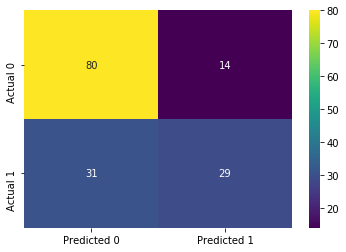

In [0]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_test, y_pred);

#### Calculate Confusion Matrix Classification Accuracy

In [0]:
# How many perdictions were made....
80 + 29

109

In [0]:
# How many total predictions were made....
len(y_test)

154

In [0]:
# What was the classification accuracy....
109/154

0.7077922077922078

### Shapely Values


In [0]:
# Getting my predictions from my catboost classifier model.....
import shap

row = X_test.iloc[[0]]

In [0]:
row

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age
444,4,117,62,12,0,29.7,30


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


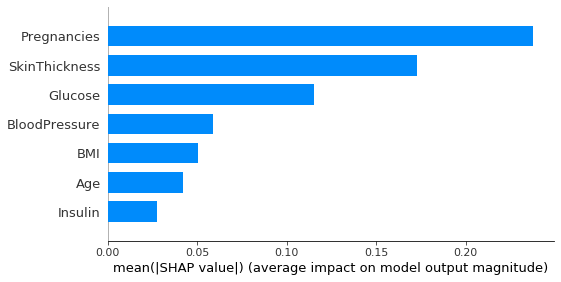

In [0]:
explainer = shap.TreeExplainer(model) # This importance featues graph is showing Pregnancies as the most influential in regards to individuality.
shap_values = explainer.shap_values(row)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [0]:
# Using a shapely force plot to understand why it predict this......
explainer = shap.TreeExplainer(model)
shap_values1 = explainer.shap_values(row)

shap.initjs()
shap.force_plot(base_value= explainer.expected_value, shap_values= shap_values1, features= row)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
# Base value is equal to mean baseline.....
explainer.expected_value, y_test.mean()

(-1.2131384564462846, 0.38961038961038963)

In [0]:
# Pregnancies shows the postive impact towards the model with the feature value being higher than the average value at -0.23
feature_names = row.columns  
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(Pregnancies, 4.0)      -0.237503
(Glucose, 117.0)        -0.115519
(BloodPressure, 62.0)   -0.058953
(SkinThickness, 12.0)   -0.172669
(Insulin, 0.0)           0.027306
(BMI, 29.7)              0.050544
(Age, 30.0)             -0.042124
dtype: float64

In [0]:
shaps.sum()

-0.5489177717370617

In [0]:
explainer.expected_value + shaps.sum()

-1.7620562281833463

In [0]:
# Here's an interative graph from Shap that correlates with the plot above. 
# Get the model's prediction
pred = model.predict(X_test)[0]

# Calculate shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Get series with shap values, feature names, & feature values
feature_names = X_test.columns
feature_values = X_test.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

# Print result
result = f'{pred:,.0f} estimated indviduals with diabetes. \n\n'
result += f'Starting from baseline of {explainer.expected_value:,.0f} \n'
result += shaps.to_string()
print(result)

# Show shapley values force plot
shap.initjs()

shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


0 estimated indviduals with diabetes. 

Starting from baseline of -1 
(Pregnancies, 4.0)      -0.237503
(Glucose, 117.0)        -0.115519
(BloodPressure, 62.0)   -0.058953
(SkinThickness, 12.0)   -0.172669
(Insulin, 0.0)           0.027306
(BMI, 29.7)              0.050544
(Age, 30.0)             -0.042124
